In [1]:
# solve imports and reload
import os
cwd = os.getcwd()
import sys
sys.path = [cwd] + sys.path
%load_ext autoreload
%autoreload 2

# external imports
import numpy as np

# internal imports
import data
import evaluation
import visualization
import geometry
import graph_cuts
import utils

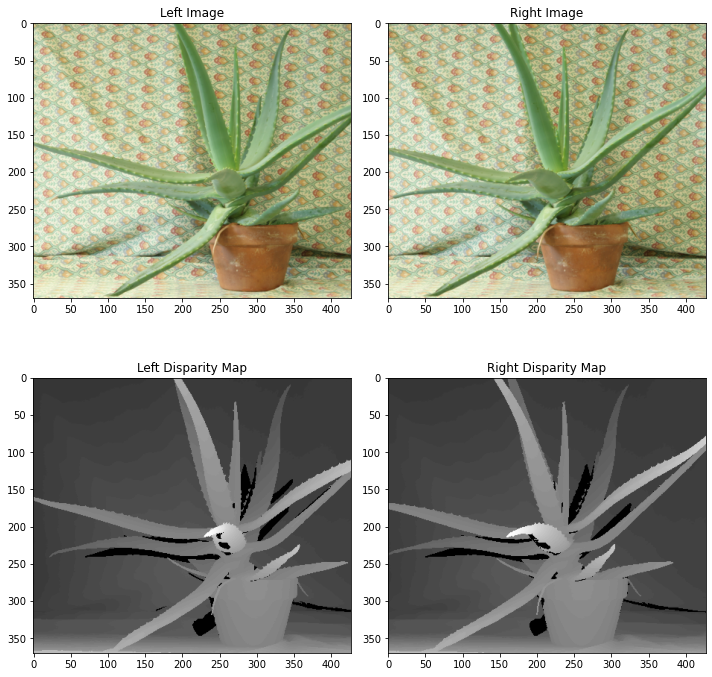

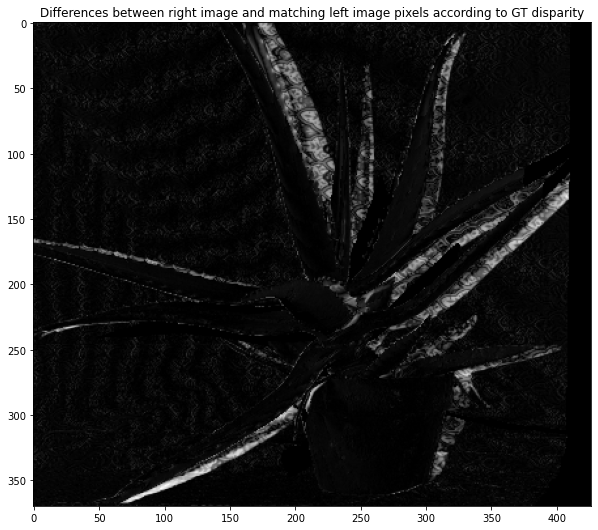

In [2]:
"""			3.1  Sanity Check			"""
# choose scene
chosen_scene = data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX]
# get images and gt disparities of scene
img_l, img_r = data.get_scene_images(chosen_scene)
d_l, d = data.get_scene_disparities(chosen_scene)
# visualize images and gt disparities
visualization.plot_scene(img_l, img_r, d_l, d)
# visualize a validation of gt disparities
differences_image = evaluation.get_disparity_rgb_distances(img_l, img_r, d)
visualization.plot_image(differences_image, "Differences between right image and matching left image pixels according to GT disparity")

In [3]:
"""			3.2  3D Plot				"""
# extract constants
h, w = img_r.shape[:2]
x_0, y_0 = geometry.get_image_center(h=h, w=w)
# get camera matrices for the two views
P_r, K_r = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
										x_0=x_0, y_0=y_0)
P_l, K_l = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=0,
										x_0=x_0, y_0=y_0)
# calculate 3d points from the two views
points_r = geometry.get_3d_points_from_disparities(disparity_map=d,
												   focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
												   x_0=x_0, y_0=y_0,
												   right_image=True)
points_l = geometry.get_3d_points_from_disparities(disparity_map=d_l,
												   focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE,
												   x_0=x_0, y_0=y_0,
												   right_image=False)
points_all = np.concatenate((points_l.reshape(4, -1), points_r.reshape(4, -1)), axis=1)
point_colors_all = np.concatenate((img_l.reshape(-1, 3), img_r.reshape(-1, 3)), axis=0)
# plot the 3D points and the camera
utils.plot_cameras(P=np.stack((P_l, P_r), axis=0),
				   K=np.stack((K_l, K_r), axis=0),
				   X=points_all,
				   title="3.2_3D_plot_reconstruction",
				   point_colors=point_colors_all)


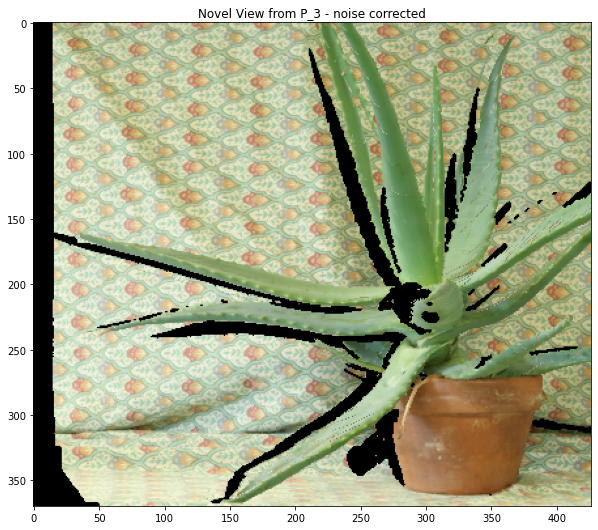

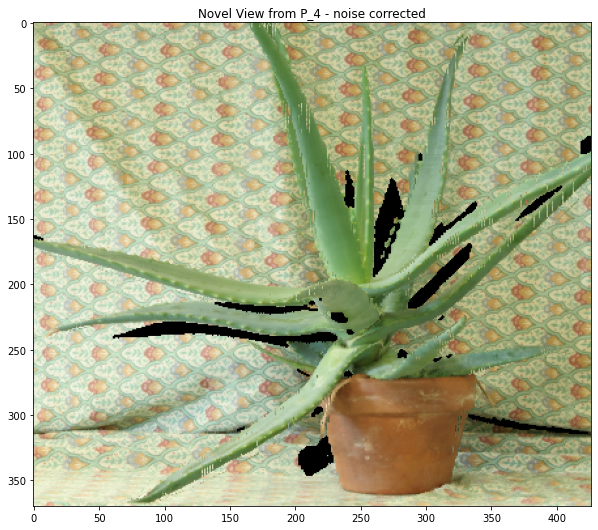

In [4]:
"""			3.3  Novel View				"""
# get camera matrices for the two views
P_3, K_3 = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=-data.BASELINE,
										x_0=x_0, y_0=y_0)
P_4, K_4 = geometry.get_camera_matrices(focal_length=data.FOCAL_LENGTH, base_line=data.BASELINE/2,
										x_0=x_0, y_0=y_0)
# generate the novel view image
novel_image_3 = geometry.novel_view_image(points=points_all.reshape(4, -1), point_colors=point_colors_all.reshape(-1, 3),
										  P=P_3, h=h, w=w)
novel_image_4 = geometry.novel_view_image(points=points_all.reshape(4, -1), point_colors=point_colors_all.reshape(-1, 3),
										  P=P_4, h=h, w=w)
# clean the novel view image
cleaned_novel_image_3 = geometry.remove_black_stripes(novel_image_3)
cleaned_novel_image_4 = geometry.remove_black_stripes(novel_image_4)
# show the novel view image
visualization.plot_image(cleaned_novel_image_3 / 255, title="Novel View from P_3 - noise corrected")
visualization.plot_image(cleaned_novel_image_4 / 255, title="Novel View from P_4 - noise corrected")


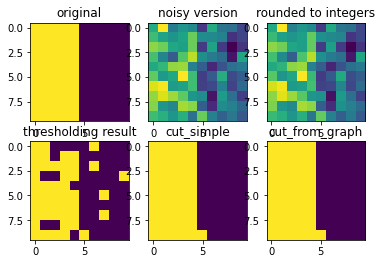

[[-23  -8   0]
 [ -8 -23  -8]
 [  0  -8 -23]]


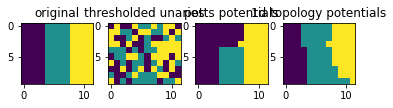

In [5]:
"""				4.1  PYGCO				"""
from pygco import cut_from_graph
import example


--------------------------------------------------
Scene Aloe:
accuracy = 3.606 
outlier_ration = 11.5%


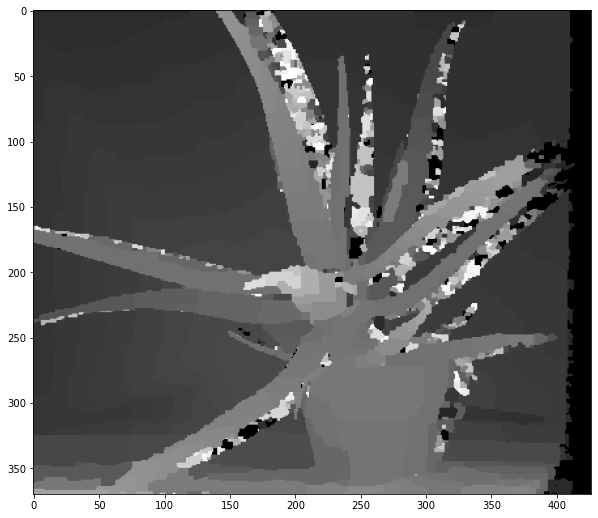

--------------------------------------------------
Scene Rocks1:


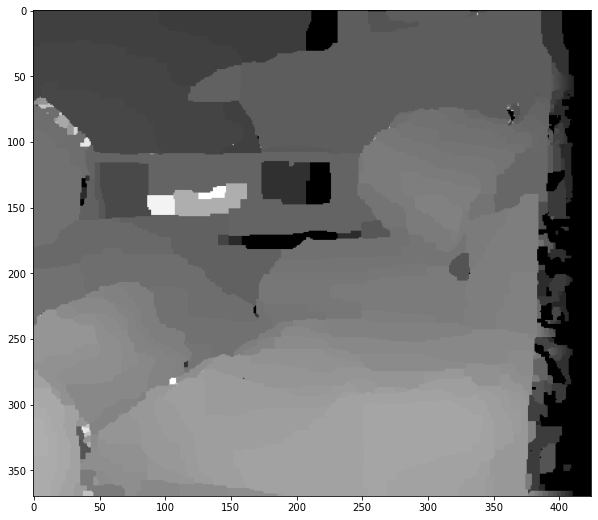

In [17]:
"""			4.2  Baseline solution		"""
K = 15
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost,
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.2")


######## pairwise_cost_l1 - K*|i-j| ########
Scene Aloe:
accuracy = 1.892 
outlier_ration = 0.083


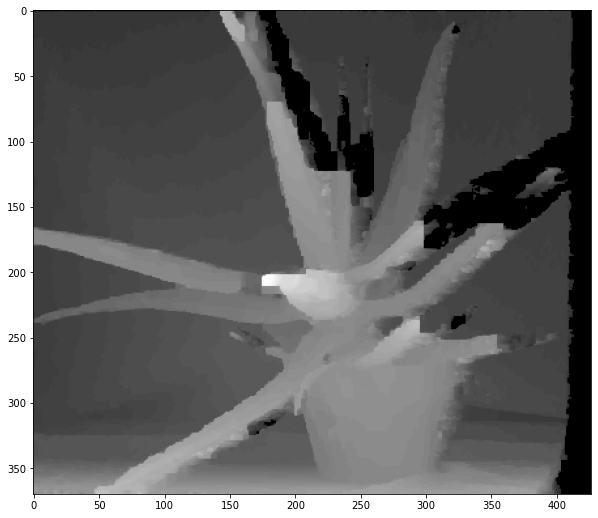

Scene Rocks1:


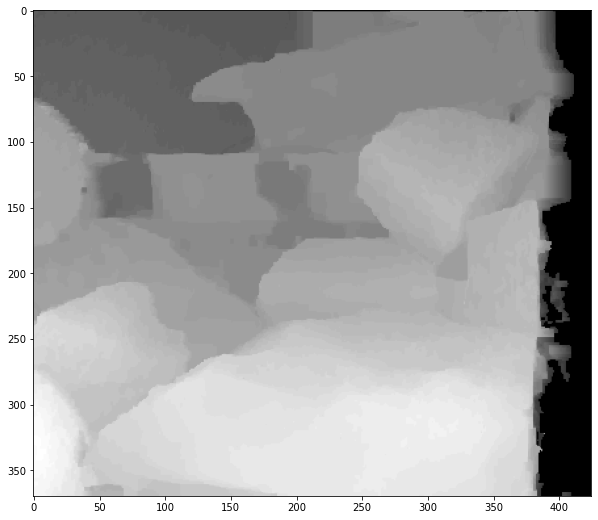

######## pairwise_cost_l1_saturated - min{ K*|i-j| , M } ########
Scene Aloe:
accuracy = 1.812 
outlier_ration = 0.070


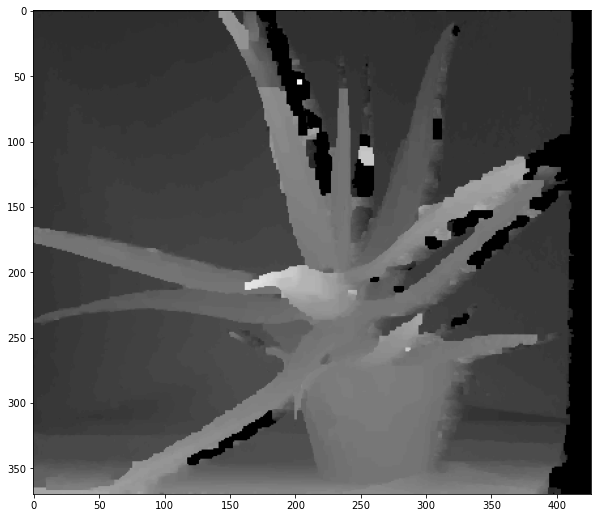

Scene Rocks1:


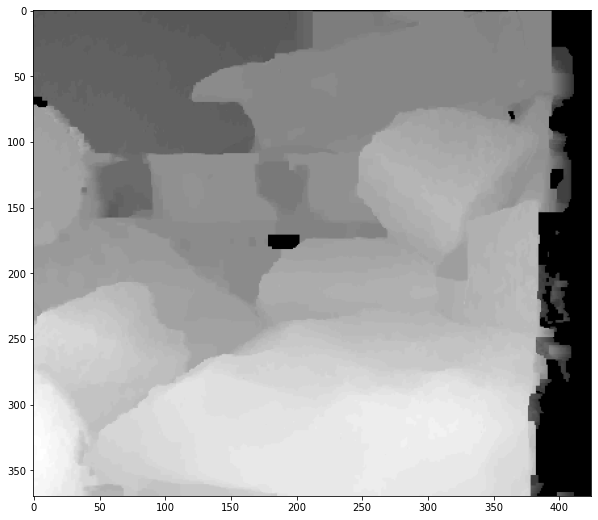

In [11]:
"""			4.3  Improvements			"""
print("######## pairwise_cost_l1 - K*|i-j| ########")
K = 3
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost,
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3")

print("######## pairwise_cost_l1_saturated - min{ K*|i-j| , M } ########")
K = 3
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost,
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3")


######## unary_cost_colored ########
Scene Aloe:
accuracy = 2.111 
outlier_ration = 0.081


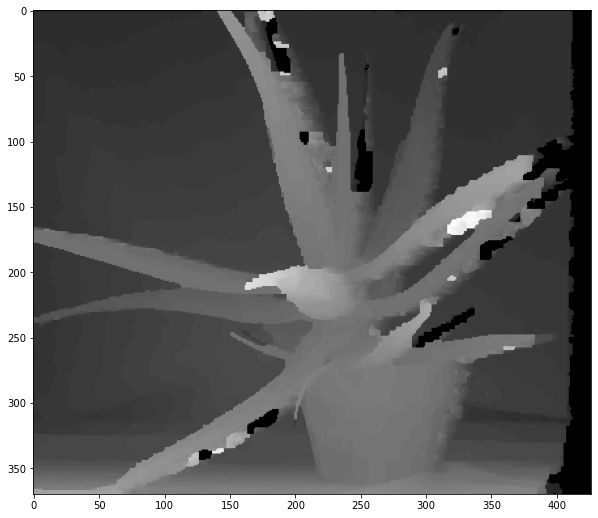

Scene Rocks1:


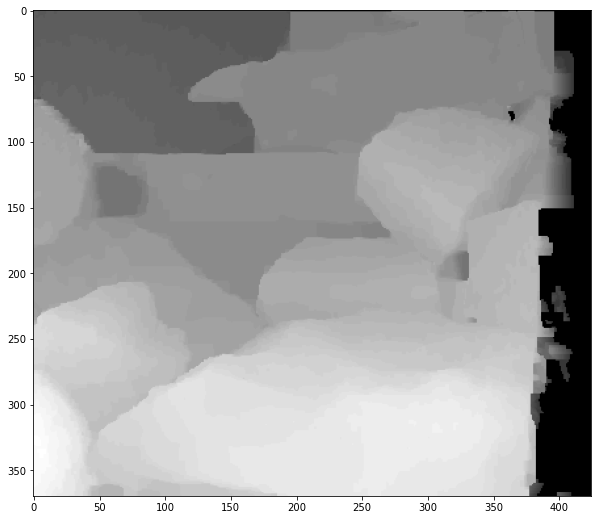

In [13]:
print("######## unary_cost_colored ########")
K = 3
for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
	graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
													get_edges_fn=graph_cuts.get_edges,
													get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
													get_pairwise_cost_kwargs=dict({"K": K}),
													get_unary_cost_fn=graph_cuts.unary_cost_colored,
													P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
													subsection="4.3")


In [ ]:
print("######## unary_cost_patches ########")
K = 3
r = 3
#for scene in [data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX],
#			  data.SCENES_WITHOUT_GT_DISPARITIES[data.CHOSEN_WITHOUT_GT_SCENE_INDEX]]:
for r in [3, 5, 7, 11]:
	for K in [1, 3, 5, 10]:
		for scale in [0.1, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5]:
			print("_________________")
			print("r:", r, "\tK:", K, "\tscale:", scale)
			scene = data.SCENES_WITH_GT_DISPARITIES[data.CHOSEN_GT_SCENE_INDEX]
			graph_cuts.images_to_disparity_map_and_3d_scene(scene=scene,
															get_edges_fn=graph_cuts.get_edges,
															get_pairwise_cost_fn=graph_cuts.pairwise_cost_l1_saturated,
															get_pairwise_cost_kwargs=dict({"K": K}),
															get_unary_cost_fn=graph_cuts.unary_cost_patches,
															get_unary_cost_kwargs=dict({"kernel_size": r, "scale": scale}),
															P_l=P_l, P_r=P_r, K_l=K_l, K_r=K_r,
															subsection="4.3", include_3d_scence=False)